In [1]:
import os
import json
import functools
from types import SimpleNamespace

import numpy
import matplotlib
from matplotlib import pyplot
import scipy.special
import scipy.optimize

from discohisto import (
    fit_normal,
    fit_cabinetry,
    fit_cabinetry_post,
    fit_linspace,
    fit_mcmc_mix,
    fit_mcmc_tfp_ham,
    region,
    limit,
    stats,
)

In [2]:
SEARCHES_PATH = "searches/"

In [3]:
@functools.cache
def load_searches():
    searches = []
    for item in os.scandir(SEARCHES_PATH):
        if not item.is_dir():
            continue
        searches.append(item.name)
        
    return sorted(searches)


def load_reported(search):
    path = os.path.join(SEARCHES_PATH, search, "reported.json")
    with open(path) as file_:
        reported = json.load(file_)
    return reported


def _get_n_region(reg):
    sr_name = reg.signal_region_name
    observations = reg.workspace

    for obs in reg.workspace["observations"]:
        if obs["name"] == sr_name:
            return obs["data"][0]

    raise ValueError(sr_name)


def _load_mcmc_limits(path, *, suffix):
    mcmc_types = ["mix", "tfp_ham"]
    lim = None
    for mcmc_type in mcmc_types:
        suffix_i = "_mcmc_%s_%s" % (mcmc_type, suffix)
        try:
            lim = limit.LimitScan.load(path, suffix=suffix_i)
        except FileNotFoundError:
            ...
    assert lim is not None
    return lim


def _load_limit(limit_dir, suffix):
    lim = limit.LimitScan.load(limit_dir, suffix=suffix)
    assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
    return lim


def _limit_logl(lim):
    return numpy.log(numpy.mean(lim.integral_zero))

In [4]:
def load_frame():
    searches = load_searches()
    
    # frame entries
    search_ = []
    region_ = []
    reported_n = []
    reported_bkg = []
    reported_bkg_hi = []
    reported_bkg_lo = []
    reported_s95obs = []
    reported_s95exp = []
    reported_s95exp_hi = []
    reported_s95exp_lo = []
    
    region_n = []
    
    # fit results
    fit_cabinetry_bkg = []
    fit_cabinetry_err = []
    fit_cabinetry_post_bkg = []
    fit_cabinetry_post_err = []
    
    # limits observed
    limit_cabinetry_logl = []
    limit_cabinetry_2obs = []
    limit_cabinetry_3obs = []
    
    limit_cabinetry_post_2obs = []
    limit_cabinetry_post_3obs = []
    
    limit_normal_logl = []
    limit_normal_2obs = []
    limit_normal_3obs = []
    
    limit_normal_log_logl = []
    limit_normal_log_2obs = []
    limit_normal_log_3obs = []
    
    limit_linspace_logl = []
    limit_linspace_2obs = []
    limit_linspace_3obs = []
    
    limit_delta_logl = []
    limit_delta_2obs = []
    limit_delta_3obs = []
    
    limit_mcmc_logl = []
    limit_mcmc_2obs = []
    limit_mcmc_3obs = []
    
    # limits expected
    limit_cabinetry_bkgexp = []
    limit_cabinetry_3exp = []
    limit_cabinetry_3exp_hi = []
    limit_cabinetry_3exp_lo = []
    
    limit_normal_bkgexp = []
    limit_normal_3exp = []
    limit_normal_3exp_hi = []
    limit_normal_3exp_lo = []
    
    limit_normal_log_bkgexp = []
    limit_normal_log_3exp = []
    limit_normal_log_3exp_hi = []
    limit_normal_log_3exp_lo = []
    
    limit_linspace_bkgexp = []
    limit_linspace_3exp = []
    limit_linspace_3exp_hi = []
    limit_linspace_3exp_lo = []
    
    limit_delta_bkgexp = []
    limit_delta_3exp = []
    limit_delta_3exp_hi = []
    limit_delta_3exp_lo = []
    
    limit_mcmc_bkgexp = []
    limit_mcmc_3exp = []
    limit_mcmc_3exp_hi = []
    limit_mcmc_3exp_lo = []
    
    for search in searches:
        reported = load_reported(search)
        for region_name in reported:
            search_.append(search)
            region_.append(region_name)
            
            # reported
            reported_reg = reported[region_name]
            
            n_observed = reported_reg["n"]
            reported_n.append(n_observed)
            reported_bkg.append(reported_reg["bkg"])
            reported_bkg_hi.append(reported_reg["bkg_hi"])
            reported_bkg_lo.append(reported_reg["bkg_lo"])
            reported_s95obs.append(reported_reg["s95obs"])
            reported_s95exp.append(reported_reg["s95exp"])
            reported_s95exp_hi.append(reported_reg["s95exp_hi"])
            reported_s95exp_lo.append(reported_reg["s95exp_lo"])
            
            # region
            region_dir = os.path.join(SEARCHES_PATH, search, region_name)
            region_i = region.Region.load(region_dir)
            region_n.append(_get_n_region(region_i))
            
            # standard fits
            fit_dir = os.path.join(region_dir, "fit")
            
            fit = fit_cabinetry.FitCabinetry.load(fit_dir)
            fit_cabinetry_bkg.append(fit.yield_pre)
            fit_cabinetry_err.append(fit.error_pre)
            
            fit = fit_cabinetry_post.FitCabinetryPost.load(fit_dir)
            fit_cabinetry_post_bkg.append(fit.yield_post)
            fit_cabinetry_post_err.append(fit.error_post)
            
            fit = fit_normal.FitNormal.load(fit_dir)
            mu_delta = fit.yield_linear
            
            # limits
            limit_dir = os.path.join(fit_dir, "limit")
            load_limit = functools.partial(_load_limit, limit_dir)
            
            # limits observed
            lim = load_limit("_cabinetry_observed")
            limit_cabinetry_logl.append(_limit_logl(lim))
            limit_cabinetry_2obs.append(lim.points[6][-1])
            limit_cabinetry_3obs.append(lim.points[7][-1])
            
            lim = load_limit("_cabinetry_post_observed")
            limit_cabinetry_post_2obs.append(lim.points[6][-1])
            limit_cabinetry_post_3obs.append(lim.points[7][-1])
            
            lim = load_limit("_normal_observed")
            limit_normal_logl.append(_limit_logl(lim))
            limit_normal_2obs.append(lim.points[6][-1])
            limit_normal_3obs.append(lim.points[7][-1])
            
            lim = load_limit("_normal_log_observed")
            limit_normal_log_logl.append(_limit_logl(lim))
            limit_normal_log_2obs.append(lim.points[6][-1])
            limit_normal_log_3obs.append(lim.points[7][-1])
            
            lim = load_limit("_linspace_observed")
            limit_linspace_logl.append(_limit_logl(lim))
            limit_linspace_2obs.append(lim.points[6][-1])
            limit_linspace_3obs.append(lim.points[7][-1])
                        
            lim = limit.LimitScanDelta.load(limit_dir, suffix="_observed")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_delta_logl.append(stats.poisson_log_minus_max(n_observed, mu_delta))
            limit_delta_2obs.append(lim.points[6][-1])
            limit_delta_3obs.append(lim.points[7][-1])
            
            lim = _load_mcmc_limits(limit_dir, suffix="observed")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_mcmc_logl.append(_limit_logl(lim))
            limit_mcmc_2obs.append(lim.points[6][-1])
            limit_mcmc_3obs.append(lim.points[7][-1])
            
            # limits expected
            lim = load_limit("_cabinetry_central")
            limit_cabinetry_bkgexp.append(lim.ndata)
            limit_cabinetry_3exp.append(lim.points[7][-1])
            lim = load_limit("_cabinetry_up")
            limit_cabinetry_3exp_hi.append(lim.points[7][-1])
            lim = load_limit("_cabinetry_down")
            limit_cabinetry_3exp_lo.append(lim.points[7][-1])
            
            lim = load_limit("_normal_central")
            limit_normal_bkgexp.append(lim.ndata)
            limit_normal_3exp.append(lim.points[7][-1])
            lim = load_limit("_normal_up")
            limit_normal_3exp_hi.append(lim.points[7][-1])
            lim = load_limit("_normal_down")
            limit_normal_3exp_lo.append(lim.points[7][-1])
            
            lim = load_limit("_normal_log_central")
            limit_normal_log_bkgexp.append(lim.ndata)
            limit_normal_log_3exp.append(lim.points[7][-1])
            lim = load_limit("_normal_log_up")
            limit_normal_log_3exp_hi.append(lim.points[7][-1])
            lim = load_limit("_normal_log_down")
            limit_normal_log_3exp_lo.append(lim.points[7][-1])
            
            lim = load_limit("_linspace_central")
            limit_linspace_bkgexp.append(lim.ndata)
            limit_linspace_3exp.append(lim.points[7][-1])
            lim = load_limit("_linspace_up")
            limit_linspace_3exp_hi.append(lim.points[7][-1])
            lim = load_limit("_linspace_down")
            limit_linspace_3exp_lo.append(lim.points[7][-1])
            
            lim = limit.LimitScanDelta.load(limit_dir, suffix="_central")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_delta_bkgexp.append(lim.ndata)
            limit_delta_3exp.append(lim.points[7][-1])
            lim = limit.LimitScanDelta.load(limit_dir, suffix="_up")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_delta_3exp_hi.append(lim.points[7][-1])
            lim = limit.LimitScanDelta.load(limit_dir, suffix="_down")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_delta_3exp_lo.append(lim.points[7][-1])
            
            lim = _load_mcmc_limits(limit_dir, suffix="central")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_mcmc_bkgexp.append(lim.ndata)
            limit_mcmc_3exp.append(lim.points[7][-1])
            lim = _load_mcmc_limits(limit_dir, suffix="up")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_mcmc_3exp_hi.append(lim.points[7][-1])
            lim = _load_mcmc_limits(limit_dir, suffix="down")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_mcmc_3exp_lo.append(lim.points[7][-1])

    out = dict(
        # labels
        search_=search_,
        region_=region_,
        # reported
        reported_n=reported_n,
        reported_bkg=reported_bkg,
        reported_bkg_hi=reported_bkg_hi,
        reported_bkg_lo=reported_bkg_lo,
        reported_s95obs=reported_s95obs,
        reported_s95exp=reported_s95exp,
        reported_s95exp_hi=reported_s95exp_hi,
        reported_s95exp_lo=reported_s95exp_lo,
        region_n=region_n,
        # fits
        fit_cabinetry_bkg=fit_cabinetry_bkg,
        fit_cabinetry_err=fit_cabinetry_err,
        fit_cabinetry_post_bkg=fit_cabinetry_post_bkg,
        fit_cabinetry_post_err=fit_cabinetry_post_err,
        # limits
        # observed limits
        limit_cabinetry_logl=limit_cabinetry_logl,
        limit_cabinetry_2obs=limit_cabinetry_2obs,
        limit_cabinetry_3obs=limit_cabinetry_3obs,
        limit_cabinetry_post_2obs=limit_cabinetry_post_2obs,
        limit_cabinetry_post_3obs=limit_cabinetry_post_3obs,
        limit_normal_logl=limit_normal_logl,
        limit_normal_2obs=limit_normal_2obs,
        limit_normal_3obs=limit_normal_3obs,
        limit_normal_log_logl=limit_normal_log_logl,
        limit_normal_log_2obs=limit_normal_log_2obs,
        limit_normal_log_3obs=limit_normal_log_3obs,
        limit_linspace_logl=limit_linspace_logl,
        limit_linspace_2obs=limit_linspace_2obs,
        limit_linspace_3obs=limit_linspace_3obs,
        limit_delta_logl=limit_delta_logl,
        limit_delta_2obs=limit_delta_2obs,
        limit_delta_3obs=limit_delta_3obs,
        limit_mcmc_logl=limit_mcmc_logl,
        limit_mcmc_2obs=limit_mcmc_2obs,
        limit_mcmc_3obs=limit_mcmc_3obs,
        # expected limits
        limit_cabinetry_bkgexp=limit_cabinetry_bkgexp,
        limit_cabinetry_3exp=limit_cabinetry_3exp,
        limit_cabinetry_3exp_hi=limit_cabinetry_3exp_hi,
        limit_cabinetry_3exp_lo=limit_cabinetry_3exp_lo,
        limit_normal_bkgexp=limit_normal_bkgexp,
        limit_normal_3exp=limit_normal_3exp,
        limit_normal_3exp_hi=limit_normal_3exp_hi,
        limit_normal_3exp_lo=limit_normal_3exp_lo,
        limit_normal_log_bkgexp=limit_normal_log_bkgexp,
        limit_normal_log_3exp=limit_normal_log_3exp,
        limit_normal_log_3exp_hi=limit_normal_log_3exp_hi,
        limit_normal_log_3exp_lo=limit_normal_log_3exp_lo,
        limit_linspace_bkgexp=limit_linspace_bkgexp,
        limit_linspace_3exp=limit_linspace_3exp,
        limit_linspace_3exp_hi=limit_linspace_3exp_hi,
        limit_linspace_3exp_lo=limit_linspace_3exp_lo,
        limit_delta_bkgexp=limit_delta_bkgexp,
        limit_delta_3exp=limit_delta_3exp,
        limit_delta_3exp_hi=limit_delta_3exp_hi,
        limit_delta_3exp_lo=limit_delta_3exp_lo,
        limit_mcmc_bkgexp=limit_mcmc_bkgexp,
        limit_mcmc_3exp=limit_mcmc_3exp,
        limit_mcmc_3exp_hi=limit_mcmc_3exp_hi,
        limit_mcmc_3exp_lo=limit_mcmc_3exp_lo,
    )
    
    return SimpleNamespace(**{key: numpy.array(value) for key, value in out.items()})
        

FRAME = load_frame()

In [5]:
print(numpy.array_equal(FRAME.reported_n, FRAME.region_n))

True


In [6]:
print(load_searches())

['atlas_susy_1Lbb_2020', 'atlas_susy_1Ljets_2021', 'atlas_susy_2L0J_2019', 'atlas_susy_2Ljets_2022', 'atlas_susy_2hadtau_2020', 'atlas_susy_3LRJmimic_2020', 'atlas_susy_3L_2021', 'atlas_susy_3Lresonance_2020', 'atlas_susy_3Lss_2019', 'atlas_susy_4L_2021', 'atlas_susy_DVmuon_2020', 'atlas_susy_compressed_2020', 'atlas_susy_hb_2019', 'atlas_susy_jets_2021']


# Compare fitted backgrounds

In [7]:
# TODO error bars

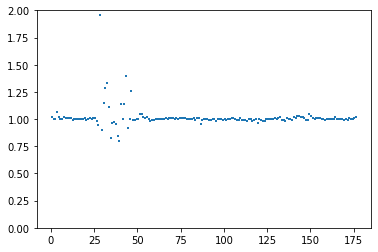

In [8]:
def plot_bkgs():
    repored_bkg = FRAME.reported_bkg
    fit_cabinetry_bkg = FRAME.fit_cabinetry_bkg

    y = fit_cabinetry_bkg / repored_bkg
    x = numpy.arange(len(y)) + 0.5
    
    pyplot.scatter(x, y, lw=0, s=2, marker=",")
    
    pyplot.ylim(0, 2)
    pyplot.show()
    
plot_bkgs()

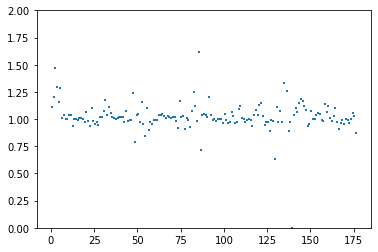

In [9]:
def plot_bkgs_post():
    repored_bkg = FRAME.reported_bkg
    fit_cabinetry_bkg = FRAME.fit_cabinetry_post_bkg

    y = fit_cabinetry_bkg / repored_bkg
    x = numpy.arange(len(y)) + 0.5
    
    pyplot.scatter(x, y, lw=0, s=2, marker=",")
    
    pyplot.ylim(0, 2)
    pyplot.show()
    
plot_bkgs_post()

# Inspect mean log likelihoods

In [10]:
def print_mean_logls():
    name_to_mean_logl = {
        "cabinetry": FRAME.limit_cabinetry_logl.mean(),
        "normal": FRAME.limit_normal_logl.mean(),
        "normal_log": FRAME.limit_normal_log_logl.mean(),
        "delta": FRAME.limit_delta_logl.mean(),
        "linspace": FRAME.limit_linspace_logl.mean(),
        "mcmc": FRAME.limit_mcmc_logl.mean(),
    }
    
    ref = max(name_to_mean_logl.values())
    
    for name, q in name_to_mean_logl.items():
        print("%15s %7.4f %7.4f" % (name, q, q - ref))

print_mean_logls()    

      cabinetry -0.6318  0.0000
         normal -0.6332 -0.0014
     normal_log -0.6324 -0.0005
          delta -0.6918 -0.0599
       linspace -0.6753 -0.0435
           mcmc -0.8220 -0.1902


      fun: 0.6315619416091265
 hess_inv: array([[ 1.05537659e+09,  1.05314745e+09, -1.60193889e+08],
       [ 1.05314745e+09,  1.05092302e+09, -1.59855532e+08],
       [-1.60193889e+08, -1.59855532e+08,  2.43155699e+07]])
      jac: array([ 6.60121441e-06, -6.61611557e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([235.02823715, 234.61382899, -35.67862285])
weights [6.02144400e-001 3.97855600e-001 1.63382351e-118 5.10780332e-103]
        mixture -0.6316 _______
         .6, .4 -0.6316 _______


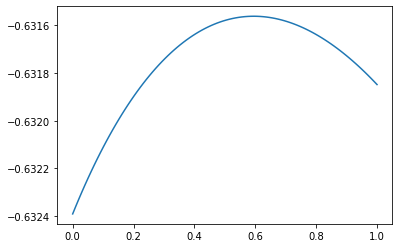

In [11]:
def print_optimized_mixture():
    name_to_mixture_part = {
        "cabinetry": FRAME.limit_cabinetry_logl,
        "normal_log": FRAME.limit_normal_log_logl,
        "linspace": FRAME.limit_linspace_logl,
        "mcmc": FRAME.limit_mcmc_logl,
    }
    
    parts = numpy.stack(list(name_to_mixture_part.values())).T
    
    def mixture_mean_logl(x):
        log_weights = log_softmax(x)
        return scipy.special.logsumexp(parts + log_weights, axis=1).mean()
    
    # logit coordinates have a shift freedom. Constrain it by setting x[-1]=0
    def loss(x_start):
        x = numpy.append(x_start, 0.0)
        return -mixture_mean_logl(x)
    
    result = scipy.optimize.minimize(
        loss,
        [0.0] * (len(name_to_mixture_part) - 1)
    )
    print(result)
    
    result_weights = numpy.exp(log_softmax(numpy.append(result.x, 0.0)))
    print("weights", result_weights)
    
    print("%15s %7.4f _______" % ("mixture", -loss(result.x)))
    x_p6_p4 = _safe_log([0.6, 0.4, 0])
    # offset to wash out the appended zero
    print("%15s %7.4f _______" % (".6, .4", -loss(x_p6_p4 + 300)))
    
    # plot a scan
    x = numpy.linspace(0, 1, 100)
    y = []
    for xi in x:
        log_weights = _safe_log([xi, 1 - xi, 0])
        # offset to wash out the appended zero
        y.append(-loss(log_weights + 700))
    pyplot.plot(x, y)
    pyplot.show()
    
    
def log_softmax(x):
    # log(e^xi / sum e^xi)
    s = x - x.max()
    return s - numpy.log(numpy.exp(s).sum())


def _safe_log(x):
    x = numpy.asarray(x)
    iszero = x == 0
    return numpy.where(iszero, -numpy.inf, numpy.log(x + iszero))


print_optimized_mixture()

# Compare observed limits

In [12]:
def plot_limits(label):
    reported_obs = FRAME.reported_s95obs
    label_2obs = getattr(FRAME, "limit_%s_2obs" % label)
    label_3obs = getattr(FRAME, "limit_%s_3obs" % label)
    
    pyplot.scatter(reported_obs, label_2obs, color="r", lw=0, s=2, marker=",")
    pyplot.scatter(reported_obs, label_3obs, color="b", lw=0, s=2, marker=",")
    pyplot.plot([0, 400], [0, 400], "k", alpha=0.2)
    
    pyplot.yscale("log")
    pyplot.xscale("log")
    pyplot.xlim(1.5, 400)
    pyplot.ylim(1.5, 400)
    
    pyplot.show()


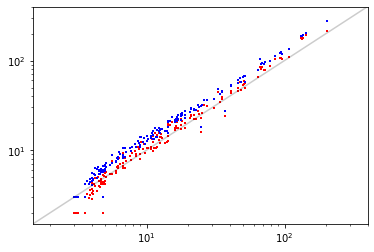

In [13]:
plot_limits("cabinetry")

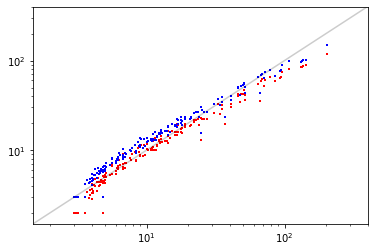

In [14]:
plot_limits("cabinetry_post")

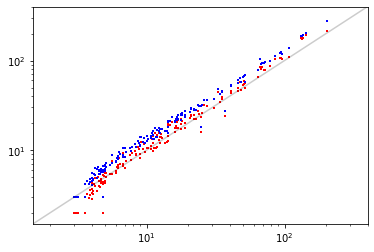

In [15]:
plot_limits("normal")

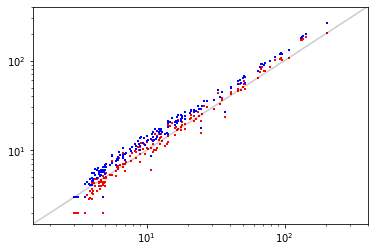

In [16]:
plot_limits("normal_log")

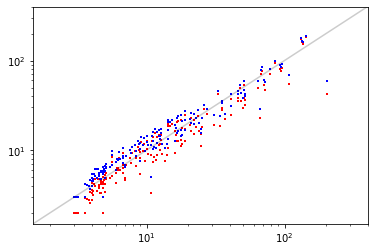

In [17]:
plot_limits("delta")

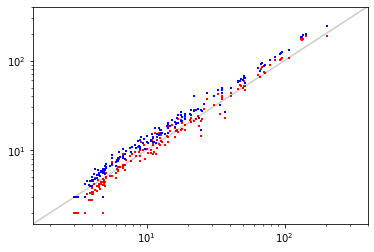

In [18]:
plot_limits("linspace")

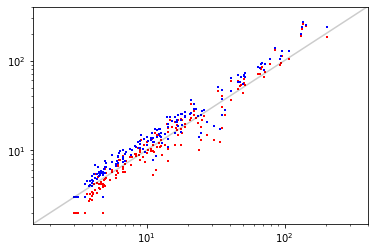

In [19]:
plot_limits("mcmc")

In [20]:
2 / numpy.log(2), numpy.exp(2)

(2.8853900817779268, 7.38905609893065)

In [21]:
3 / numpy.log(2), numpy.exp(3)

(4.328085122666891, 20.085536923187668)

# Inspect anomalous differences

In [22]:
def print_anomalies(label):
    search_ = FRAME.search_
    region_ = FRAME.region_
    reported_obs = FRAME.reported_s95obs
    label_2obs = getattr(FRAME, "limit_%s_2obs" % label)
    
    parts = zip(search_, region_, reported_obs, label_2obs)
    
    for search_i, region_i, reported_i, label_i in parts:
        error = numpy.log(label_i / reported_i)
        if not abs(error) > 0.3:
            continue
            
        print(
            "%28s %28s %6.1f %6.1f %6.1f" % 
            (search_i, region_i, reported_i, label_i, error)
        )

In [23]:
print_anomalies("cabinetry")

        atlas_susy_1Lbb_2020                   SR_LM_disc   36.8   24.1   -0.4
        atlas_susy_1Lbb_2020                   SR_MM_disc   24.8   15.8   -0.4
      atlas_susy_2Ljets_2022                     ewk_high    3.0    2.0   -0.4
      atlas_susy_2Ljets_2022                     ewk_llbb    3.0    2.0   -0.4
 atlas_susy_3Lresonance_2020             SRFR_270_300_all    3.6    2.0   -0.6
 atlas_susy_3Lresonance_2020             SRFR_300_330_all    6.7    9.3    0.3
 atlas_susy_3Lresonance_2020             SRFR_400_440_all    3.2    2.0   -0.5
 atlas_susy_3Lresonance_2020             SRFR_580_inf_all    3.0    2.0   -0.4
 atlas_susy_3Lresonance_2020             SR4l_170_190_all   14.2   19.5    0.3
 atlas_susy_3Lresonance_2020             SR4l_360_400_all    3.0    2.0   -0.4
 atlas_susy_3Lresonance_2020             SR4l_580_inf_all    4.0    2.8   -0.3
 atlas_susy_3Lresonance_2020              SR3l_90_110_all    4.8    2.0   -0.9
 atlas_susy_3Lresonance_2020             SR3l_400_44

In [24]:
print_anomalies("linspace")

        atlas_susy_1Lbb_2020                   SR_LM_disc   36.8   23.1   -0.5
        atlas_susy_1Lbb_2020                   SR_MM_disc   24.8   14.5   -0.5
        atlas_susy_2L0J_2019             SR_DF_0J_100_inf   34.1   25.2   -0.3
        atlas_susy_2L0J_2019             SR_SF_1J_100_120   27.3   37.1    0.3
      atlas_susy_2Ljets_2022                     ewk_high    3.0    2.0   -0.4
      atlas_susy_2Ljets_2022                     ewk_llbb    3.0    2.0   -0.4
 atlas_susy_3Lresonance_2020             SRFR_130_150_all    3.8    2.8   -0.3
 atlas_susy_3Lresonance_2020             SRFR_270_300_all    3.6    2.0   -0.6
 atlas_susy_3Lresonance_2020             SRFR_400_440_all    3.2    2.0   -0.5
 atlas_susy_3Lresonance_2020             SRFR_580_inf_all    3.0    2.0   -0.4
 atlas_susy_3Lresonance_2020             SR4l_360_400_all    3.0    2.0   -0.4
 atlas_susy_3Lresonance_2020             SR4l_580_inf_all    4.0    2.8   -0.4
 atlas_susy_3Lresonance_2020              SR3l_90_11

# Check orderings re expected

In [25]:
def print_orderings(label):
    search_ = FRAME.search_
    region_ = FRAME.region_
    reported_n = FRAME.reported_n
    bkg = getattr(FRAME, "limit_%s_bkgexp" % label)
    exp = getattr(FRAME, "limit_%s_3exp" % label)
    obs = getattr(FRAME, "limit_%s_3obs" % label)
    
    parts = zip(search_, region_, bkg, reported_n, exp, obs)
    
    any_ = False
    
    for search_i, region_i, bkg_i, n_i, exp_i, obs_i in parts:
        excess_data = n_i > bkg_i
        excess_limit = obs_i > exp_i
        
        if excess_data == excess_limit:
            continue
            
        any_ = True
            
        print(
            "%28s %28s %6.1f %6d %6.1f %6.1f" % 
            (search_i, region_i, bkg_i, n_i, exp_i, obs_i)
        )
        
    if not any_:
        print("ALL OK %r" % label)

In [26]:
print_orderings("cabinetry")

ALL OK 'cabinetry'


In [27]:
print_orderings("normal")

ALL OK 'normal'


In [28]:
print_orderings("normal_log")

ALL OK 'normal_log'


In [29]:
print_orderings("linspace")

ALL OK 'linspace'


In [30]:
print_orderings("delta")

ALL OK 'delta'


In [31]:
print_orderings("mcmc")

ALL OK 'mcmc'
